In [44]:
import sys
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from data_loader import load_track_json_files, extract_mood_labeled_tracks, map_tags_to_mood
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

In [45]:
sys.path.append("../src")

# Set path to your subset
folder = "../data/raw/lastfm_subset"

# Load all JSON track files
all_tracks = load_track_json_files(folder)

# Filter to only mood-related tracks
mood_tracks = extract_mood_labeled_tracks(all_tracks)

# Assign mood label
for t in mood_tracks:
    t["mood"] = map_tags_to_mood(t["tags"])

In [47]:
df = pd.DataFrame(mood_tracks)
print(f"Found {len(df)} mood-tagged tracks.")
df = df[df["mood"].notna()]
print(f"Tracks with valid mood labels: {len(df)}")

audio_df = pd.read_csv("../features.csv")

merged_df = pd.merge(df, audio_df, on="track_id", how="inner")
print(f"Matched {len(merged_df)} mood-labeled tracks with audio features.")

clean_df = merged_df[
    (merged_df["tempo"] > 0) &
    (merged_df["loudness"] != 0) &
    (merged_df["key"] != -1) &
    (merged_df["mode"].isin([0, 1])) &
    (merged_df["duration"] > 0)
].dropna()

print(f"Cleaned dataset size: {len(clean_df)}")
# for col in merged_df.columns:
#     if not merged_df[col].apply(lambda x: isinstance(x, list)).any():
#         print(f"Unique values in {col}: {merged_df[col].unique()}")
#     else:
#         print(f"Skipped column '{col}' (contains lists)")


Found 2111 mood-tagged tracks.
Tracks with valid mood labels: 2104
Matched 2104 mood-labeled tracks with audio features.
Cleaned dataset size: 2100


In [48]:
feature_cols = ["tempo", "loudness", "duration", "key", "mode", "time_signature"]
X = clean_df[feature_cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Isolated songs: 0


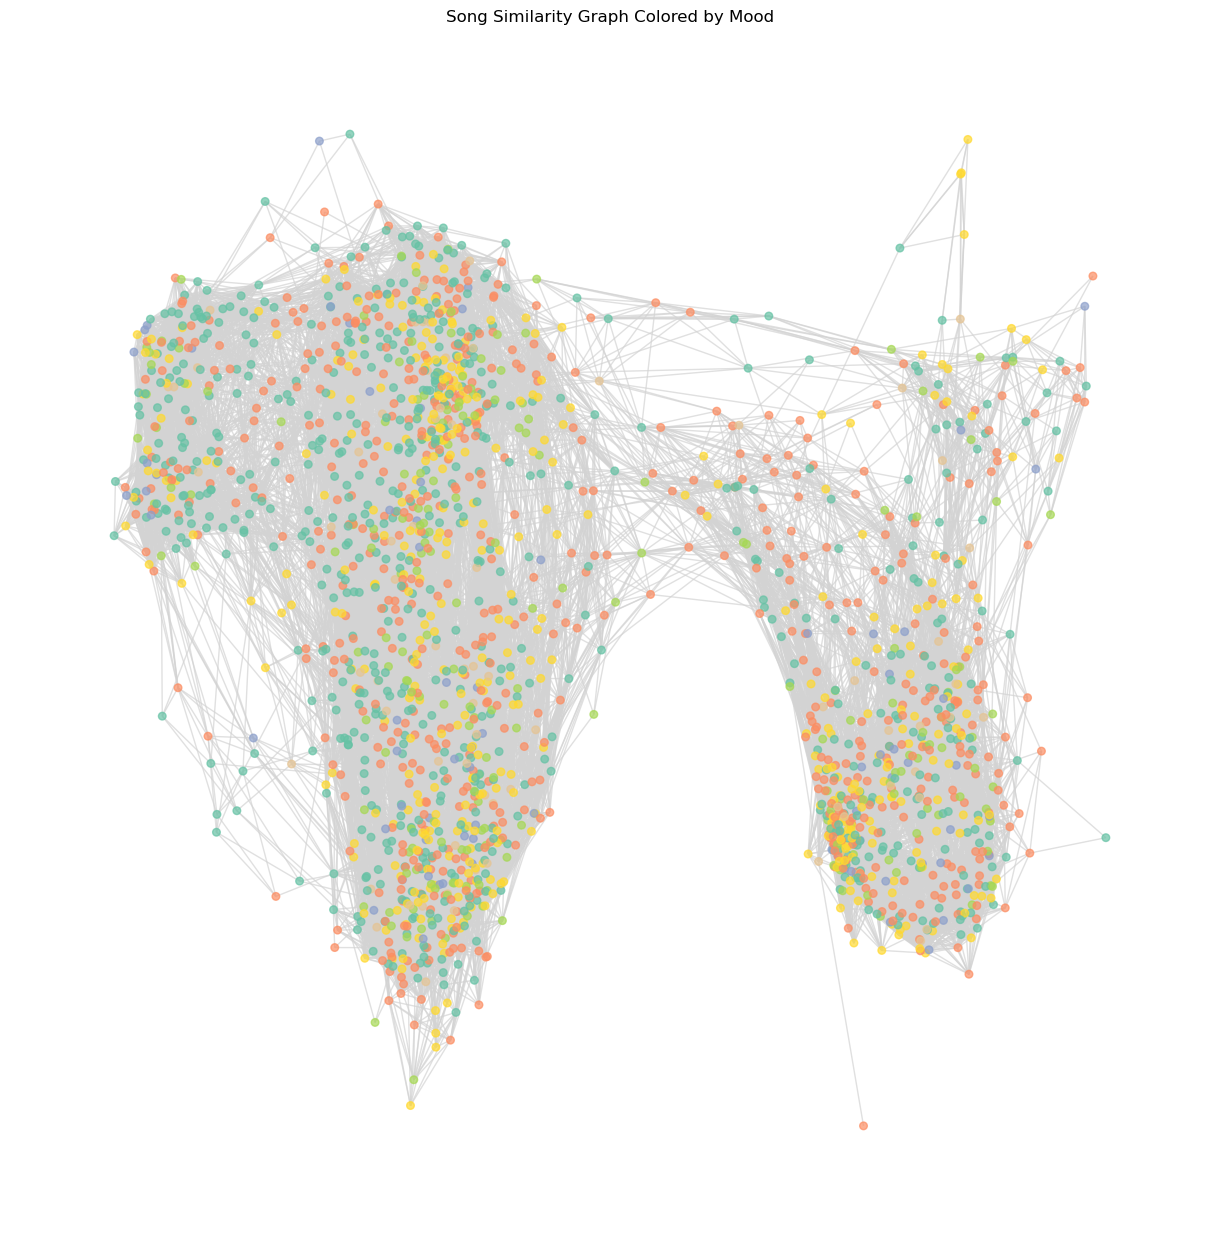

In [ ]:
similarity_matrix = cosine_similarity(X_scaled)

G = nx.Graph()

for idx, row in clean_df.iterrows():
    G.add_node(row["track_id"], 
               title=row["title"], 
               artist=row["artist"], 
               mood=row["mood"])

track_ids = clean_df["track_id"].values
threshold = 0.85  # experiment with this later

for i in range(len(track_ids)):
    for j in range(i + 1, len(track_ids)):
        sim = similarity_matrix[i, j]
        if sim > threshold:
            G.add_edge(track_ids[i], track_ids[j], weight=sim)


isolated = list(nx.isolates(G))
print(f"Isolated songs: {len(isolated)}")

# Assign colors by mood
moods = list(set(nx.get_node_attributes(G, 'mood').values()))
color_map = {mood: plt.cm.Set2(i / len(moods)) for i, mood in enumerate(moods)}
node_colors = [color_map[G.nodes[n]['mood']] for n in G.nodes]

plt.figure(figsize=(12, 12))
nx.draw_spring(G, 
               node_color=node_colors,
               node_size=30, 
               edge_color='lightgray', 
               alpha=0.7,
               with_labels=False)
plt.title("Song Similarity Graph Colored by Mood")
plt.show()

#continue with GNN
#organise the code chunks into scripts